In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.test.is_built_with_cuda()
import os, sys
sys.path.append('../')
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import pyarrow.parquet as pq

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from datasets import WindowedGaitDataset, ToTensor
from training_utils import convert_cov_mat_to_vector, convert_unique_cov_vector_to_mat, unscale_cov_mat
from training_utils import unscale_kinematics, unscale_gait_state, scale_gait_state
from torch_training_utils import enum_parameters
from save_best_model import SaveBestModel

from gait_kinematics_model import GaitModel, HeteroscedasticModel

import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42


random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#RUN THIS ON COLAB
ON_COLAB = False
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/Phase ML Data/'


In [3]:
!gsutil cp -r gs://ml_gait_estimation/r01_ordered_corrupt_time.csv .

Copying gs://ml_gait_estimation/r01_ordered_corrupt_time.csv...
- [1 files][301.3 MiB/301.3 MiB]                                                
Operation completed over 1 objects/301.3 MiB.                                    


In [4]:
!gsutil cp -r gs://ml_gait_estimation/r01_randomized_corrupt_time.csv .

Copying gs://ml_gait_estimation/r01_randomized_corrupt_time.csv...
\ [1 files][301.6 MiB/301.6 MiB]                                                
Operation completed over 1 objects/301.6 MiB.                                    


In [5]:
!gsutil cp -r gs://ml_gait_estimation/dataport_ordered_corrupt_time.csv .

Copying gs://ml_gait_estimation/dataport_ordered_corrupt_time.csv...
/ [1 files][506.4 MiB/506.4 MiB]                                                
Operation completed over 1 objects/506.4 MiB.                                    


In [6]:
!gsutil cp -r gs://ml_gait_estimation/dataport_randomized_corrupt_time.csv .

Copying gs://ml_gait_estimation/dataport_randomized_corrupt_time.csv...
| [1 files][507.1 MiB/507.1 MiB]                                                
Operation completed over 1 objects/507.1 MiB.                                    


In [7]:
!gsutil cp -r gs://ml_gait_estimation/gt_ordered_corrupt_time.csv .

Copying gs://ml_gait_estimation/gt_ordered_corrupt_time.csv...
\ [1 files][558.0 MiB/558.0 MiB]                                                
Operation completed over 1 objects/558.0 MiB.                                    


In [8]:
!gsutil cp -r gs://ml_gait_estimation/gt_randomized_corrupt_time.csv .

Copying gs://ml_gait_estimation/gt_randomized_corrupt_time.csv...
| [1 files][558.3 MiB/558.3 MiB]                                                
Operation completed over 1 objects/558.3 MiB.                                    


In [11]:
window_size = 10
meas_scale = np.array([[-69.35951035,  27.62815047],\
                        [-456.18013759,  401.13782617],\
                        [-63.71649984,  22.06632622],\
                        [-213.4786175,   396.93801619],\
                        [-35.26603985,  20.78473636],\
                        [-20.95456523,  14.63961137],\
                          [0,1]])

speed_scale = (0,2)
incline_scale = (-10,10)
stair_height_scale = (-0.2,0.2)

filename_dataport_ordered = 'dataport_ordered_stairs_label_corrupt_time.csv'
filename_dataport_randomized = 'dataport_randomized_stairs_label_corrupt_time.csv'

filename_r01_ordered = 'r01_ordered_stairs_label_corrupt_time.csv'
filename_r01_randomized = 'r01_randomized_stairs_label_corrupt_time.csv'

filename_gt_ordered = 'gt_ordered_stairs_label_corrupt_time.csv'
filename_gt_randomized = 'gt_randomized_stairs_label_corrupt_time.csv'

if ON_COLAB:
    filename_r01_ordered = drive_path+filename_r01_ordered
    filename_r01_randomized = drive_path+filename_r01_randomized
    filename_dataport_ordered = drive_path+filename_dataport_ordered
    filename_dataport_randomized = drive_path+filename_dataport_randomized
    filename_gt_ordered = drive_path+filename_gt_ordered
    filename_gt_randomized = drive_path+filename_gt_randomized
    

DO_DECIMATION = not True
if DO_DECIMATION:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized, nrows=10000)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered, nrows=10000)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered, nrows=10000)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized, nrows=10000)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered, nrows=10000)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized, nrows=10000)

    
else:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized)


# REMOVE RANDOM SUBJECTS FOR X-VALIDATION
#FROM R01, remove two: AB02 and AB06
#FROM DATAPORT, remove three: AB09, AB05, and AB10
#FROM GT, remove six, AB25, AB28, AB30, AB20, AB12, AB09
REMOVE_SUBS_XVAL = True

#r01 ordered
index_sub_remove_r01 = gait_data_r01_ordered[ (gait_data_r01_ordered['subj_id'] == 2) | (gait_data_r01_ordered['subj_id'] == 6) ].index
gait_data_r01_ordered_val = gait_data_r01_ordered.iloc[index_sub_remove_r01]
gait_data_r01_ordered.drop(index_sub_remove_r01 , inplace=True)

#r01 randomized
index_sub_remove_r01 = gait_data_r01_randomized[ (gait_data_r01_randomized['subj_id'] == 2) | (gait_data_r01_randomized['subj_id'] == 6) ].index
gait_data_r01_randomized_val = gait_data_r01_randomized.iloc[index_sub_remove_r01]
gait_data_r01_randomized.drop(index_sub_remove_r01 , inplace=True)

print(gait_data_r01_ordered.head())
print(gait_data_r01_ordered_val.head())

#dataport ordered
index_sub_remove_dataport = gait_data_dataport_ordered[ (gait_data_dataport_ordered['subj_id'] == 9) | 
                                                       (gait_data_dataport_ordered['subj_id'] == 5) |
                                                      (gait_data_dataport_ordered['subj_id'] == 10)].index

gait_data_dataport_ordered_val = gait_data_dataport_ordered.iloc[index_sub_remove_dataport]
gait_data_dataport_ordered.drop(index_sub_remove_dataport , inplace=True)

#dataport randomized
index_sub_remove_dataport = gait_data_dataport_randomized[ (gait_data_dataport_randomized['subj_id'] == 9) | 
                                                       (gait_data_dataport_randomized['subj_id'] == 5) |
                                                      (gait_data_dataport_randomized['subj_id'] == 10)].index

gait_data_dataport_randomized_val = gait_data_dataport_randomized.iloc[index_sub_remove_dataport]
gait_data_dataport_randomized.drop(index_sub_remove_dataport , inplace=True)

#gt ordered
index_sub_remove_gt = gait_data_gt_ordered[ (gait_data_gt_ordered['subj_id'] == 25) | 
                                           (gait_data_gt_ordered['subj_id'] == 28) |
                                          (gait_data_gt_ordered['subj_id'] == 30) |
                                          (gait_data_gt_ordered['subj_id'] == 20) |
                                          (gait_data_gt_ordered['subj_id'] == 12) |
                                          (gait_data_gt_ordered['subj_id'] == 9)].index

gait_data_gt_ordered_val = gait_data_gt_ordered.iloc[index_sub_remove_gt]
gait_data_gt_ordered.drop(index_sub_remove_gt , inplace=True)

#gt randomized
index_sub_remove_gt = gait_data_gt_randomized[ (gait_data_gt_randomized['subj_id'] == 25) | 
                                           (gait_data_gt_randomized['subj_id'] == 28) |
                                          (gait_data_gt_randomized['subj_id'] == 30) |
                                          (gait_data_gt_randomized['subj_id'] == 20) |
                                          (gait_data_gt_randomized['subj_id'] == 12) |
                                          (gait_data_gt_randomized['subj_id'] == 9)].index

gait_data_gt_randomized_val = gait_data_gt_randomized.iloc[index_sub_remove_gt]
gait_data_gt_randomized.drop(index_sub_remove_gt , inplace=True)

#concatenate
gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                      gait_data_dataport_ordered, gait_data_dataport_randomized,\
                      gait_data_gt_ordered, gait_data_gt_randomized])

gait_data_val = pd.concat([gait_data_r01_ordered_val, gait_data_r01_randomized_val,\
                          gait_data_dataport_ordered_val, gait_data_dataport_randomized_val,\
                          gait_data_gt_ordered_val, gait_data_gt_randomized_val])

train_dataset = WindowedGaitDataset(gait_data=gait_data,
                                            meas_scale=meas_scale,
                                            window_size = window_size,
                                            speed_scale = speed_scale,
                                            incline_scale = incline_scale,
                                            stair_height_scale=stair_height_scale,
                                            transform=ToTensor())

val_dataset = WindowedGaitDataset(gait_data=gait_data_val,
                                            meas_scale=meas_scale,
                                            window_size = window_size,
                                            speed_scale = speed_scale,
                                            incline_scale = incline_scale,
                                            stair_height_scale=stair_height_scale,
                                            transform=ToTensor())

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

DO_DECIMATION = not True
if DO_DECIMATION:
#decimate data


    # Calculate the number of samples to include in each set.
    train_size_keep = int(0.1 * len(train_dataset))
    train_size_discard = len(train_dataset) - train_size_keep
    
    val_size_keep = int(0.1 * len(val_dataset))
    val_size_discard = len(val_dataset) - val_size_keep


    # Divide the dataset by randomly selecting samples.
    train_dataset, _ = random_split(train_dataset, [train_size_keep, train_size_discard])
    val_dataset, _ = random_split(val_dataset, [val_size_keep, val_size_discard])

    print('{:>5,} training samples'.format(train_size_keep))
    print('{:>5,} validation samples'.format(val_size_keep))

print(val_dataset[0]['meas'][-1,:])
print(val_dataset[1]['meas'][-1,:])
print(val_dataset[2]['meas'][-1,:])






   foot_angle  foot_vel_angle  shank_angle  shank_vel_angle  heel_acc_forward  \
0    9.713109     -122.000000     6.810365       -54.155000          0.000000   
1    7.928249     -133.739183     5.993880       -61.785706         -3.391320   
2    7.120444     -147.077747     5.606053       -70.516308         -7.078094   
3    5.217823     -162.450106     4.621966       -84.205665         -3.548601   
4    3.440199     -167.100286     3.626258       -93.718654         -1.555049   

   heel_acc_upward     phase  speed  incline  stair_height  is_moving  \
0         0.000000  0.000968    0.8    -10.0           0.0        1.0   
1         2.057084  0.013282    0.8    -10.0           0.0        1.0   
2         4.304541  0.018221    0.8    -10.0           0.0        1.0   
3         2.657375  0.028783    0.8    -10.0           0.0        1.0   
4         1.422208  0.038366    0.8    -10.0           0.0        1.0   

   stride_count  HSDetected  subj_id        dt      time  
0             1

In [12]:
#SET BATCH SIZE
BATCH_SIZE_TRAIN = 512
BATCH_SIZE_VALIDATE = 2048
NUM_WORKERS = 8
# NUM_WORKERS = 4

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            shuffle=True,
            batch_size = BATCH_SIZE_TRAIN, # Trains with this batch size.
            pin_memory=True,
            num_workers=NUM_WORKERS
        )


# For validation the order doesn't matter, so we'll just read them sequentially.
#try shuffle off see if it fixes
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            shuffle=True,
            batch_size = BATCH_SIZE_VALIDATE, # Evaluate with this batch size.
            pin_memory=True,
            num_workers=NUM_WORKERS
        )

In [13]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

model_nickname = 'heteroscedastic-covariance-model'
# model_nickname = 'TEST'

output_dir = f'../staging_area/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    output_dir = f'../staging_area/{model_nickname}/model_save_xval/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

checkpoint_dir = 'checkpoints/'
if not os.path.exists(output_dir+checkpoint_dir):
    os.makedirs(output_dir+checkpoint_dir)





Saving model to ../staging_area/heteroscedastic-covariance-model/model_save_xval/


In [29]:
# def convert_cov_mat_to_vector(cov_mat):
#     #handle batched inputs in the first dimension
#     if len(cov_mat.shape) == 3:
#         B = cov_mat.shape[0]
#         N = cov_mat.shape[1]
#     else:
#         N = cov_mat.shape[0]
#     #set up the length of the flattened vector of the unique variances
#     L = np.sum([i+1 for i in range(N)])
    
#     if len(cov_mat.shape) == 3:
#         flattened_output = np.zeros((B,L))
#         for jj in range(B):
#             start_idx = 0
#             for i in range(0,N):
#                 row = cov_mat[jj,i,i:N]
#                 flattened_output[jj,start_idx:start_idx+(N-i)] = row
#                 start_idx += N-i
                
#     else:
#         flattened_output = np.zeros((L,))
#         start_idx = 0
#         for i in range(0,N):
#             print('dfghjkl')
#             row = cov_mat[i,i:N]
#             print(row)
#             flattened_output[start_idx:start_idx+(N-i)] = row
#             print(flattened_output)
#             start_idx += N-i
            
#     return flattened_output


V = np.random.rand(2,3,3)
print(V)
print(convert_cov_mat_to_vector(V))

[[[0.37454012 0.95071431 0.73199394]
  [0.59865848 0.15601864 0.15599452]
  [0.05808361 0.86617615 0.60111501]]

 [[0.70807258 0.02058449 0.96990985]
  [0.83244264 0.21233911 0.18182497]
  [0.18340451 0.30424224 0.52475643]]]
[[0.37454012 0.95071431 0.73199394 0.15601864 0.15599452 0.60111501]
 [0.70807258 0.02058449 0.96990985 0.21233911 0.18182497 0.52475643]]


In [ ]:
# SET UP GAIT MODEL
dim_val = 64 # 
n_hidden_layers=4
input_size = 6 # The number of input variables. 1 if univariate forecasting.
num_predicted_features = 6 # The number of output variables. 
# )

gait_model = GaitModel(
    input_size=input_size,
    num_predicted_features=num_predicted_features,
    dim_val=dim_val,  
    n_hidden_layers=n_hidden_layers
)


if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
gait_model.to(device)

best_model_name = 'best_heteroscedastic_model.tar'
save_best_model = SaveBestModel(output_dir+best_model_name)

model_nickname = 'gait-model'
model_dir = f'../full_models/{model_nickname}/model_save_xval/'
checkpoint = torch.load(model_dir+'best_gait_model.tar')
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss: {loss}')
gait_model.load_state_dict(g)

epoch = checkpoint['epoch']

# Put gait model in evaluation mode
gait_model.eval()

# class HeteroscedasticModel(nn.Module):

#     def __init__(self, 
#         input_size=6,
#         num_predicted_features=6,
#         batch_first=True,
#         dim_val=512,  
#         n_hidden_layers=2,
#         log_covar_element_scale = np.array(
#             [[-4.60517019,  6.59583506],
#              [-4.60517019,  8.00316999],
#              [-4.60517019,  6.23502258],
#              [-4.60517019,  7.62349018],
#              [-4.60517019,  5.32510388],
#              [-4.60517019,  5.17364564],
#              [-2.21500356, 11.25173026],
#              [-4.60517019,  7.68459809],
#              [-4.60517019, 10.49797692],
#              [-4.60517019,  7.5181146 ],
#              [-4.60517019,  7.29806282],
#              [-4.60517019,  6.26124854],
#              [-4.60517019,  7.33407139],
#              [-4.60517019,  4.83793644],
#              [-4.60517019,  4.87319887],
#              [-1.83459664, 10.27920013],
#              [-4.60517019,  7.15667353],
#              [-4.60517019,  6.91650956],
#              [-4.60517019,  5.75253599],
#              [-4.60517019,  4.40803868],
#              [-4.60517019,  5.3568463 ]])
#         ): 

#         super().__init__() 

#         #print("input_size is: {}".format(input_size))
#         #print("dim_val is: {}".format(dim_val))
#         self.num_predicted_features = num_predicted_features
#         self.input_size = input_size
#         self.hidden_layers = []

#         for i in range(n_hidden_layers):
#             self.hidden_layers.extend([nn.Linear(in_features=dim_val, out_features=dim_val), nn.GELU()])
            
#         self.hidden_layers = nn.ModuleList(self.hidden_layers)
        
#         self.embedding_layer = nn.Linear(in_features=input_size, out_features=dim_val)
#         self.output_layer = nn.Linear(in_features=dim_val, out_features=num_predicted_features)        
          
#         self.log_covar_element_scale = log_covar_element_scale

#     def forward(self, x):        
#         x = self.embedding_layer(x)
        
#         for i, layer in enumerate(self.hidden_layers):
#             x = layer(x)
        
#         x = self.output_layer(x)
#         return x
    
#     def scale_unique_log_covar_elements(self, unique_covar_elements):
#         rows, cols = unique_covar_elements.shape
#         scaled_covar_mat = np.zeros((rows,cols))

#         for i in range(cols):
#             scale_lb = self.log_covar_element_scale[i,0]
#             scale_ub = self.log_covar_element_scale[i,1]
#             # print(scale_lb, scale_ub)
#             scaled_covar_mat[:,i] = (unique_covar_elements[:,i] - scale_lb) * (1/(scale_ub - scale_lb))
#             # input()
#         return scaled_covar_mat
    
#     def unscale_unique_log_covar_elements(self, unique_covar_elements):
        
#         rows, cols = unique_covar_elements.shape
#         unscaled_covar_mat = np.zeros((rows,cols))

#         for i in range(cols):
#             scale_lb = self.log_covar_element_scale[i,0]
#             scale_ub = self.log_covar_element_scale[i,1]
#             unscaled_covar_mat[:,i] = (unique_covar_elements[:,i] * (scale_ub - scale_lb)) + scale_lb
#         return unscaled_covar_mat
            
#     def process_unique_covar_elements(self, unique_covar_elements):
#         #need unique_covar_elements to be N x 21
#         processed_unique_covar_elements = self.unscale_unique_log_covar_elements(unique_covar_elements)
#         processed_unique_covar_elements = np.exp(processed_unique_covar_elements)
#         return processed_unique_covar_elements


#SET UP HETEROSCEDASTIC MODEL
dim_val = 64 # 
n_hidden_layers=2
input_size = 2 # The number of input variables. 1 if univariate forecasting.
num_predicted_variables = 6
num_predicted_features = np.sum([i+1 for i in range(num_predicted_variables)]) # The number of output variables. 
# )

heteroscedastic_model = HeteroscedasticModel(
    input_size=input_size,
    num_predicted_features=num_predicted_features,
    dim_val=dim_val,  
    n_hidden_layers=n_hidden_layers
)

    
enum_parameters(heteroscedastic_model)

heteroscedastic_model.to(device)

#set up heterscedastic model scaling factors
log_covar_element_scale = np.array(
            [[-4.60517019,  6.59583506],
             [-4.60517019,  8.00316999],
             [-4.60517019,  6.23502258],
             [-4.60517019,  7.62349018],
             [-4.60517019,  5.32510388],
             [-4.60517019,  5.17364564],
             [-2.21500356, 11.25173026],
             [-4.60517019,  7.68459809],
             [-4.60517019, 10.49797692],
             [-4.60517019,  7.5181146 ],
             [-4.60517019,  7.29806282],
             [-4.60517019,  6.26124854],
             [-4.60517019,  7.33407139],
             [-4.60517019,  4.83793644],
             [-4.60517019,  4.87319887],
             [-1.83459664, 10.27920013],
             [-4.60517019,  7.15667353],
             [-4.60517019,  6.91650956],
             [-4.60517019,  5.75253599],
             [-4.60517019,  4.40803868],
             [-4.60517019,  5.3568463 ]])


optimizer = torch.optim.Adam(heteroscedastic_model.parameters(), lr=1e-3, betas=(0.9, 0.998), eps=1e-9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, threshold=0.01, verbose=True,min_lr=1e-6)

start_epoch = 0


epochs = 2
SAVE_EVERY_EPOCH_N = 1
first_batch = next(iter(train_dataloader))


    
#define loss function
lossfcn = nn.MSELoss()

#Extract index for time steps
DT_IDX = 6

training_RMSEs = []
validation_RMSEs = []

import time
import datetime

# Measure the total training time for the whole run.
total_t0 = time.time()




def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



for epoch_i in range(start_epoch, start_epoch+epochs):
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, start_epoch+epochs))
    print('Training...')
    
    # lr = scheduler.get_lr()
    lr = optimizer.param_groups[0]['lr']
    print(f'Learning Rate: {lr}')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    heteroscedastic_model.train()
    step_ct = 0
    for step, batch in enumerate(train_dataloader):
    # for step, batch in enumerate([first_batch] * 200):
        step_ct += 1
        

        
        optimizer.zero_grad()   
        
        b_kinematics = batch['meas'].to(device)
        
        #extract only kinematics from last frame
        b_kinematics = b_kinematics[:,-1,:-1]
                
        b_state = batch['state'].to(device)
        
        
        # Run the gait model
        with torch.no_grad():
            kinematic_predictions = gait_model(b_state)
        
        
        #extract only phase elements from b_state
        b_state = b_state[:,:,0:2]
        # print(b_state[0:2,:,:])
        # input()
        
        #compute differences
        #unscale
        kinematic_predictions = kinematic_predictions.detach().to('cpu').numpy()
        b_kinematics = b_kinematics.to('cpu').numpy()
        kinematic_predictions = np.squeeze(kinematic_predictions, axis=1)
        
        kinematic_predictions = unscale_kinematics(kinematic_predictions, meas_scale)
        b_kinematics = unscale_kinematics(b_kinematics, meas_scale)
        
        #compute covariances
        diff_kinematics = kinematic_predictions - b_kinematics
        diff_kinematics = np.expand_dims(diff_kinematics, axis=1)
        
        # print('diff_kinematics')
        # print(diff_kinematics.shape)
        # print(diff_kinematics[0,:,:])
        # print(diff_kinematics[1,:,:])
        # input()
        
        covariances_batch = np.einsum('ijk,ikl->ijl', np.transpose(diff_kinematics,(0,2,1)), diff_kinematics)
        
        # print('covariances_batch')
        # print(covariances_batch.shape)
        # print(covariances_batch[0,:,:])
        # print(covariances_batch[1,:,:])
        # input()
        
        
        #extract unique elements of covariance
        covariance_unique_elements = convert_cov_mat_to_vector(covariances_batch)
        # print(covariance_unique_elements.shape)
        
        
        #floor covariance elements to prevent division by zero errors
        covariance_unique_elements[covariance_unique_elements<1e-2] = 1e-2
        # print(covariance_unique_elements.shape)
        
        #process elements 
        #first take the log of the covariances
        covariance_unique_elements = np.log(covariance_unique_elements)
        # print(covariance_unique_elements[0])
        # print(covariance_unique_elements.shape)
        #next, scale the elements
        covariance_unique_elements = heteroscedastic_model.scale_unique_log_covar_elements(covariance_unique_elements)
        # print(covariance_unique_elements)
        # print(covariance_unique_elements.shape)
        
        # #add extra dim 
        covariance_unique_elements = np.expand_dims(covariance_unique_elements, axis=1)
        
        #convert to torch 
        covariance_unique_elements = torch.from_numpy(covariance_unique_elements).float().to(device)
        # print(covariance_unique_elements.shape)
        
        #predict covariances
        predicted_covariance = heteroscedastic_model(b_state)
        # print(predicted_covariance.shape)
        # input()
        
        loss = lossfcn(predicted_covariance, covariance_unique_elements)
        # print(loss)

        loss.backward()

        optimizer.step()

        loss_value = loss.item()

        # Progress update every 40 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            print(loss_value)
            print(covariance_unique_elements[0,:,:])
            print(predicted_covariance[0,:,:])
            
            print(covariance_unique_elements[1,:,:])
            print(predicted_covariance[1,:,:])

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss_value
        
    # Update the learning rate.
    #if StepLR
    # scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / step_ct           
    training_RMSEs.append(avg_train_loss)
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    # Save to checkpoints
    if (epoch_i + 1) % SAVE_EVERY_EPOCH_N == 0:
        print('Saving model checkpoint')
        model_name = f"heteroscedastic_model_checkpoint_{epoch_i + 1}.tar"
        path_name = output_dir+checkpoint_dir+model_name
        print(path_name)
        torch.save({
                    'epoch':epoch_i + 1,
                    'model_state_dict': heteroscedastic_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    }, path_name)

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    heteroscedastic_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    
    
    step_ct = 0
    for batch in validation_dataloader:
    #for batch in train_dataloader:
    # for step, batch in enumerate([first_batch] * 10):
        step_ct += 1

        b_kinematics = batch['meas'].to(device)
        #extract only kinematics from last frame
        b_kinematics = b_kinematics[:,-1,:-1]
        
        b_state = batch['state'].to(device)
        
        
        # Run the gait model
        with torch.no_grad():
            kinematic_predictions = gait_model(b_state)
            
            #extract only phase elements from b_state
            b_state = b_state[:,:,0:2]
        
            #compute differences
            #unscale
            kinematic_predictions = kinematic_predictions.detach().to('cpu').numpy()
            b_kinematics = b_kinematics.to('cpu').numpy()
            kinematic_predictions = np.squeeze(kinematic_predictions, axis=1)

            kinematic_predictions = unscale_kinematics(kinematic_predictions, meas_scale)
            b_kinematics = unscale_kinematics(b_kinematics, meas_scale)
            
            #compute covariances
            diff_kinematics = kinematic_predictions - b_kinematics
            diff_kinematics = np.expand_dims(diff_kinematics, axis=1)

            # print('diff_kinematics')
            # print(diff_kinematics.shape)
            # print(diff_kinematics[0,:,:])
            # print(diff_kinematics[1,:,:])
            # input()

            covariances_batch = np.einsum('ijk,ikl->ijl', np.transpose(diff_kinematics,(0,2,1)), diff_kinematics)

            #extract unique elements of covariance
            covariance_unique_elements = convert_cov_mat_to_vector(covariances_batch)
        
            #floor covariance elements to prevent division by zero errors
            covariance_unique_elements[covariance_unique_elements<1e-2] = 1e-2
            # print(covariance_unique_elements.shape)

            #process elements 
            #first take the log of the covariances
            covariance_unique_elements = np.log(covariance_unique_elements)
            # print(covariance_unique_elements[0])
            # print(covariance_unique_elements.shape)
            #next, scale the elements
            covariance_unique_elements = heteroscedastic_model.scale_unique_log_covar_elements(covariance_unique_elements)
            # print(covariance_unique_elements)
            # print(covariance_unique_elements.shape)

            # #add extra dim 
            covariance_unique_elements = np.expand_dims(covariance_unique_elements, axis=1)

            #convert to torch 
            covariance_unique_elements = torch.from_numpy(covariance_unique_elements).float().to(device)
            # print(covariance_unique_elements.shape)

            #predict covariances
            predicted_covariance = heteroscedastic_model(b_state)

            loss = lossfcn(predicted_covariance, covariance_unique_elements)

            loss_value = loss.item()
            #print(loss_rmse)

        

        # Accumulate the validation loss.
        total_eval_loss += loss_value


    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / step_ct
    
    #schedule PlateauLoss
    scheduler.step(avg_val_loss)
    
    validation_RMSEs.append(avg_val_loss)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    #save best model
    save_best_model(
        avg_val_loss, epoch_i+1, heteroscedastic_model, optimizer, lossfcn
    )
    
    #print training vals
    print('Training vals')
    print(validation_RMSEs)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

print("Saving model to %s" % output_dir)

#save model params
model_name = 'heteroscedastic_model_params.pt'
torch.save(heteroscedastic_model.state_dict(), output_dir+model_name)

model_name = 'heteroscedastic_model_full.pt'
torch.save(heteroscedastic_model, output_dir+model_name)

#save checkpoint
model_name = f"heteroscedastic_model_checkpoint_{epoch_i + 1}.tar"
torch.save({'epoch': epoch_i + 1,
                      'model_state_dict': heteroscedastic_model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'loss': loss.item(),
                      }, path_name)

Using GPU.
Lowest Loss: 0.035824309887171175
Total Trainable Params: 9877

======== Epoch 1 / 2 ========
Training...
Learning Rate: 0.001
  Batch   100  of  23,359.    Elapsed: 0:00:10.
0.09524384140968323
tensor([[5.0508e-01, 6.7270e-01, 6.7892e-01, 3.2807e-10, 4.0401e-10, 6.5444e-01,
         6.6205e-01, 8.2864e-01, 2.6563e-10, 3.3093e-10, 7.7490e-01, 8.3393e-01,
         3.3603e-10, 4.2485e-10, 8.5477e-01, 5.0170e-01, 7.0129e-01, 3.4821e-10,
         7.3847e-01, 4.4511e-10, 7.1691e-01]], device='cuda:0')
tensor([[0.6978, 0.4303, 0.5526, 0.4471, 0.3645, 0.4958, 0.7413, 0.4102, 0.6166,
         0.4374, 0.4083, 0.6667, 0.4173, 0.3587, 0.4298, 0.7065, 0.4192, 0.4314,
         0.6335, 0.3401, 0.6802]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[9.2874e-01, 3.1819e-10, 9.2443e-01, 3.2807e-10, 8.1099e-01, 8.5801e-01,
         6.5506e-01, 3.2644e-10, 7.6384e-01, 3.3093e-10, 3.3704e-10, 8.8706e-01,
         3.3603e-10, 8.1240e-01, 8.4492e-01, 7.5042e-01, 3.4110e-10, 3.4821e-10,
    

0.09318956837678097


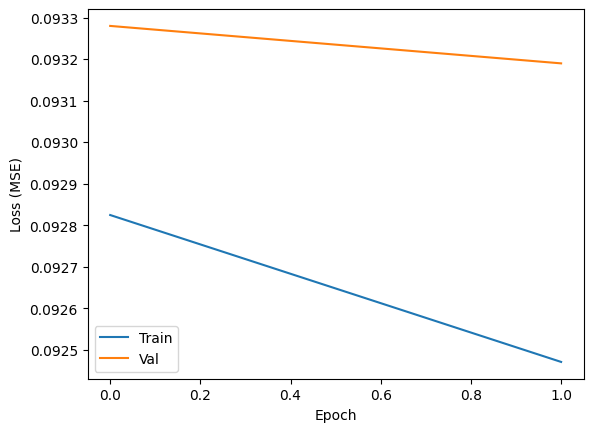

In [18]:
training_RMSEs = np.array(training_RMSEs)
validation_RMSEs = np.array(validation_RMSEs)
fig, axs = plt.subplots()
axs.plot(training_RMSEs,'-',label='Train')
axs.set_ylabel('Loss (MSE)')
axs.plot(validation_RMSEs,'-',label='Val')
axs.set_xlabel('Epoch')
axs.legend()
print(np.min(validation_RMSEs))

Using GPU.
Lowest Loss: 0.09318956837678097


Text(0.5, 0, 'Phase')

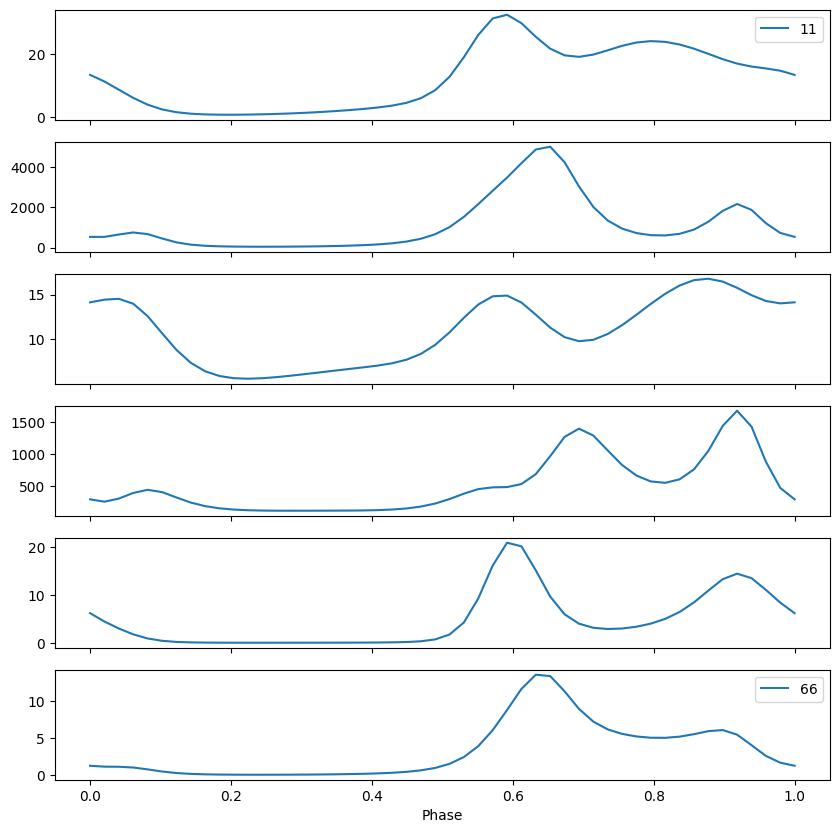

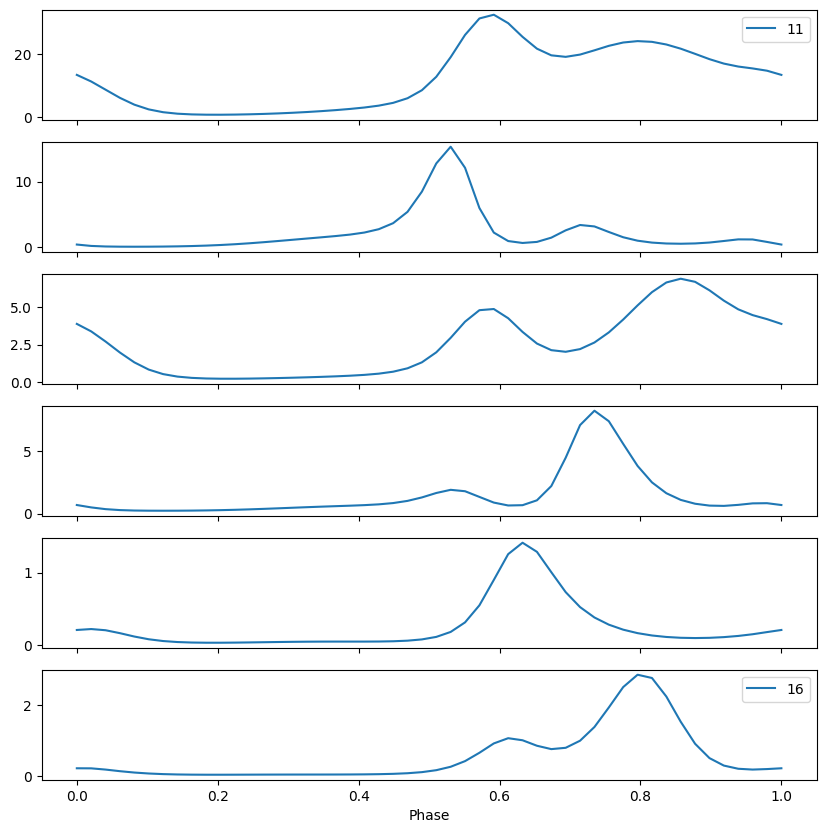

In [19]:
#SET UP HETEROSCEDASTIC MODEL
dim_val = 64 # 
n_hidden_layers=2
input_size = 2 # The number of input variables. 1 if univariate forecasting.
num_predicted_variables = 6
num_predicted_features = np.sum([i+1 for i in range(num_predicted_variables)]) # The number of output variables. 
# )

best_model = HeteroscedasticModel(
    input_size=input_size,
    num_predicted_features=num_predicted_features,
    dim_val=dim_val,  
    n_hidden_layers=n_hidden_layers
)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
best_model.to(device)


model_nickname = 'heteroscedastic-covariance-model'
REMOVE_SUBS_XVAL = True
model_dir = f'../staging_area/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    model_dir = f'../staging_area/{model_nickname}/model_save_xval/'

checkpoint = torch.load(model_dir+'best_heteroscedastic_model.tar')
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss: {loss}')
best_model.load_state_dict(g)

epoch = checkpoint['epoch']

# Put model in evaluation mode
best_model.eval()


phase_vec = np.linspace(0,1)
speed = 1
incline = 0
stair_height = 0
is_moving = 1

speed_scale = (0,2)
incline_scale = (-10,10)
stair_height_scale = (-0.2,0.2)
meas_scale = np.array([[-69.35951035,  27.62815047],\
                        [-456.18013759,  401.13782617],\
                        [-63.71649984,  22.06632622],\
                        [-213.4786175,   396.93801619],\
                        [-35.26603985,  20.78473636],\
                        [-20.95456523,  14.63961137],\
                          [0,1]])


cov_vec_11 = np.zeros(phase_vec.shape)
cov_vec_22 = np.zeros(phase_vec.shape)
cov_vec_33 = np.zeros(phase_vec.shape)
cov_vec_44 = np.zeros(phase_vec.shape)
cov_vec_55 = np.zeros(phase_vec.shape)
cov_vec_66 = np.zeros(phase_vec.shape)


cov_vec_11 = np.zeros(phase_vec.shape)
cov_vec_12 = np.zeros(phase_vec.shape)
cov_vec_13 = np.zeros(phase_vec.shape)
cov_vec_14 = np.zeros(phase_vec.shape)
cov_vec_15 = np.zeros(phase_vec.shape)
cov_vec_16 = np.zeros(phase_vec.shape)


for i in range(len(phase_vec)):
    b_state = np.array([[phase_vec[i],speed,incline,stair_height,is_moving]])
    b_state = scale_gait_state(b_state, speed_scale, incline_scale, stair_height_scale)
    b_state = torch.from_numpy(b_state).float().to(device)
    b_state = torch.unsqueeze(b_state,dim=0)
    
    b_state = b_state[:,:,0:2]
    # print(phase_vec[i])

    # print(b_state)
    # print(b_state.device)

    with torch.no_grad():
        h_vec = best_model(b_state)
    
    #convert to numpy
    h_vec = h_vec.detach().to('cpu').numpy().squeeze(axis=1)
    # print(h_vec.shape)
    
    #apply unscale and exp operations
    h_vec = best_model.process_unique_covar_elements(h_vec)
    
    # print(h_vec)
    cov_mat = convert_unique_cov_vector_to_mat(h_vec,dim_mat=6)
    # print(cov_mat)
    # print('cov_mat')
    # print(cov_mat)
    # input()

    cov_vec_11[i] = cov_mat[0,0]
    cov_vec_22[i] = cov_mat[1,1]
    cov_vec_33[i] = cov_mat[2,2]
    cov_vec_44[i] = cov_mat[3,3]
    cov_vec_55[i] = cov_mat[4,4]
    cov_vec_66[i] = cov_mat[5,5]
    
    cov_vec_11[i] = cov_mat[0,0]
    cov_vec_12[i] = cov_mat[0,1]
    cov_vec_13[i] = cov_mat[0,2]
    cov_vec_14[i] = cov_mat[0,3]
    cov_vec_15[i] = cov_mat[0,4]
    cov_vec_16[i] = cov_mat[0,5]


fig, axs = plt.subplots(6,1,figsize=(10,10),sharex=True)

axs[0].plot(phase_vec, cov_vec_11,label='11')
axs[0].legend()
axs[1].plot(phase_vec, cov_vec_22,label='22')
axs[2].plot(phase_vec, cov_vec_33,label='33')
axs[3].plot(phase_vec, cov_vec_44,label='44')
axs[4].plot(phase_vec, cov_vec_55,label='55')
axs[5].plot(phase_vec, cov_vec_66,label='66')
axs[-1].legend()
axs[-1].set_xlabel('Phase')


fig, axs = plt.subplots(6,1,figsize=(10,10),sharex=True)

axs[0].plot(phase_vec, cov_vec_11,label='11')
axs[0].legend()
axs[1].plot(phase_vec, cov_vec_12,label='12')
axs[2].plot(phase_vec, cov_vec_13,label='13')
axs[3].plot(phase_vec, cov_vec_14,label='14')
axs[4].plot(phase_vec, cov_vec_15,label='15')
axs[5].plot(phase_vec, cov_vec_16,label='16')
axs[-1].legend()
axs[-1].set_xlabel('Phase')



In [20]:
!gsutil cp -r ../staging_area/heteroscedastic-covariance-model ../full_models/
!zip -r ../full_models/heteroscedastic-covariance-model.zip ../full_models/heteroscedastic-covariance-model/
!gsutil cp -r ../full_models/heteroscedastic-covariance-model/ gs://ml_gait_estimation/full_models/
!gsutil cp ../full_models/heteroscedastic-covariance-model.zip gs://ml_gait_estimation/full_models/


Copying file://../staging_area/heteroscedastic-covariance-model/model_save_xval/heteroscedastic_model_full.pt...
Copying file://../staging_area/heteroscedastic-covariance-model/model_save_xval/best_heteroscedastic_model.tar...
Copying file://../staging_area/heteroscedastic-covariance-model/model_save_xval/heteroscedastic_model_params.pt...
Copying file://../staging_area/heteroscedastic-covariance-model/model_save_xval/checkpoints/heteroscedastic_model_checkpoint_3.tar...
/ [4 files][253.1 KiB/253.1 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://../staging_area/heteroscedastic-covariance-model/model_save_xval/checkpoints/heteroscedastic_model_checkpoint_5.tar...
Copying file://../staging_area/heteroscedastic-covariance